In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
sns.set_style("darkgrid")

In [ ]:
## mount__drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_response = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/crm/Retail_Data_Response.csv') 
df_transactions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/crm/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [ ]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
df_transactions.sort_values(by= ['customer_id','trans_date'], inplace=True) 
df_transactions.head()

,customer_id,trans_date,tran_amount
77247,CS1112,2011-06-15,56
89149,CS1112,2011-08-19,96
68206,CS1112,2011-10-02,60
36486,CS1112,2012-04-08,56
93074,CS1112,2012-06-24,52


In [ ]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


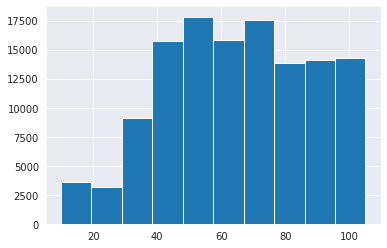

In [ ]:
df_transactions['tran_amount'].hist()

In [ ]:
#Data Preparation
df_transactions['size_s'] =  df_transactions['tran_amount'].apply(lambda x : 1 if x < 40 else 0  )
df_transactions['size_m'] =  df_transactions['tran_amount'].apply(lambda x :  1 if x >= 40 and x < 80 else 0 )
df_transactions['size_l'] =  df_transactions['tran_amount'].apply(lambda x : 1 if x > 80 else 0) 
#df_transactions = df_transactions.drop(columns = ['pre_transacrion'])
df_transactions['pre_transaction']= df_transactions.groupby( ['customer_id'],as_index=False)['trans_date'].shift(1)
#df_transactions.rename(columns={'pre_visited':'pre_transaction'},inplace=True)
#df_transactions = df_transactions.drop(columns = ['pre_transacrion'])
df_transactions.head()

,customer_id,trans_date,tran_amount,size_s,size_m,size_l,pre_transaction
77247,CS1112,2011-06-15,56,0,1,0,NaT
89149,CS1112,2011-08-19,96,0,0,1,2011-06-15
68206,CS1112,2011-10-02,60,0,1,0,2011-08-19
36486,CS1112,2012-04-08,56,0,1,0,2011-10-02
93074,CS1112,2012-06-24,52,0,1,0,2012-04-08


In [ ]:
#df_transactions = df_transactions.drop(columns = ['pre_transaction'])

In [ ]:
import datetime as dt
#dt.date(2017,12,27).weekday()
df_transactions['isweekend'] = df_transactions['trans_date'].dt.weekday.apply(lambda x : 1 if x >= 5 else 0  )
df_transactions['isweekday'] = df_transactions['trans_date'].dt.weekday.apply(lambda x : 0 if x >= 5 else 1  )

In [ ]:
## sample check data 
df_transactions[df_transactions.customer_id == 'CS1112']

,customer_id,trans_date,tran_amount,size_s,size_m,size_l,pre_transaction,isweekend,isweekday
77247,CS1112,2011-06-15,56,0,1,0,NaT,0,1
89149,CS1112,2011-08-19,96,0,0,1,2011-06-15,0,1
68206,CS1112,2011-10-02,60,0,1,0,2011-08-19,1,0
36486,CS1112,2012-04-08,56,0,1,0,2011-10-02,1,0
93074,CS1112,2012-06-24,52,0,1,0,2012-04-08,1,0
67735,CS1112,2012-07-03,81,0,0,1,2012-06-24,0,1
89734,CS1112,2012-09-16,72,0,1,0,2012-07-03,1,0
40368,CS1112,2012-12-15,76,0,1,0,2012-09-16,1,0
87839,CS1112,2013-03-01,105,0,0,1,2012-12-15,0,1
42084,CS1112,2013-07-01,36,1,0,0,2013-03-01,0,1


In [ ]:
## Date Diff data 
df_transactions['date_diff'] = -( df_transactions.pre_transaction - df_transactions.trans_date ).dt.days
df_transactions.head()

,customer_id,trans_date,tran_amount,size_s,size_m,size_l,pre_transaction,isweekend,isweekday,date_diff
77247,CS1112,2011-06-15,56,0,1,0,NaT,0,1,NaN
89149,CS1112,2011-08-19,96,0,0,1,2011-06-15,0,1,65.0
68206,CS1112,2011-10-02,60,0,1,0,2011-08-19,1,0,44.0
36486,CS1112,2012-04-08,56,0,1,0,2011-10-02,1,0,189.0
93074,CS1112,2012-06-24,52,0,1,0,2012-04-08,1,0,77.0


In [ ]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,size_s,size_m,size_l,pre_transaction,isweekend,isweekday,date_diff,recent
77247,CS1112,2011-06-15,56,0,1,0,NaT,0,1,NaN,1371.0
89149,CS1112,2011-08-19,96,0,0,1,2011-06-15,0,1,65.0,1306.0
68206,CS1112,2011-10-02,60,0,1,0,2011-08-19,1,0,44.0,1262.0
36486,CS1112,2012-04-08,56,0,1,0,2011-10-02,1,0,189.0,1073.0
93074,CS1112,2012-06-24,52,0,1,0,2012-04-08,1,0,77.0,996.0


In [ ]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),               # Monetary Value           
                                                     'size_s' : 'sum',
                                                     'size_m': 'sum',
                                                     'size_l' : 'sum',
                                                     'date_diff': 'mean',    
                                                      'isweekend' : 'sum',
                                                      'isweekday' : 'sum' ,
                                                     'date_diff': 'std'
                                                     })
df_rfm.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value'}, inplace=True)
df_rfm.head()

,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday
customer_id,,,,,,,,,
CS1112,62.0,15,1012,2,9,4,50.873523,5,10
CS1113,36.0,20,1490,1,9,10,54.685812,3,17
CS1114,33.0,19,1432,1,9,9,73.693168,6,13
CS1115,12.0,22,1659,0,13,9,55.413425,6,16
CS1116,204.0,13,857,0,8,4,107.361010,1,12


In [ ]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday
0,CS1112,62.0,15,1012,2,9,4,50.873523,5,10
1,CS1113,36.0,20,1490,1,9,10,54.685812,3,17
2,CS1114,33.0,19,1432,1,9,9,73.693168,6,13
3,CS1115,12.0,22,1659,0,13,9,55.413425,6,16
4,CS1116,204.0,13,857,0,8,4,107.361010,1,12


In [ ]:
df_rfm['ticket_size'] = df_rfm['monetary_value'] / df_rfm['frequency']
df_rfm.head()

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size
0,CS1112,62.0,15,1012,2,9,4,50.873523,5,10,67.466667
1,CS1113,36.0,20,1490,1,9,10,54.685812,3,17,74.500000
2,CS1114,33.0,19,1432,1,9,9,73.693168,6,13,75.368421
3,CS1115,12.0,22,1659,0,13,9,55.413425,6,16,75.409091
4,CS1116,204.0,13,857,0,8,4,107.361010,1,12,65.923077


In [ ]:
## **Calculating response rate**
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


<function matplotlib.pyplot.show>

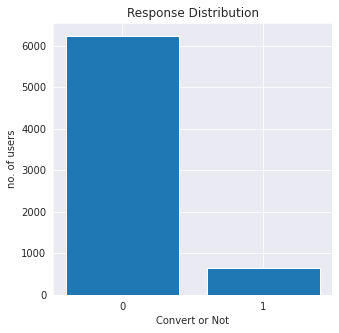

In [ ]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show


In [ ]:
# response_rate.head() #df_response
total_response =  pd.merge(df_rfm,df_response,left_on= 'customer_id',right_on = 'customer_id', how = 'inner')

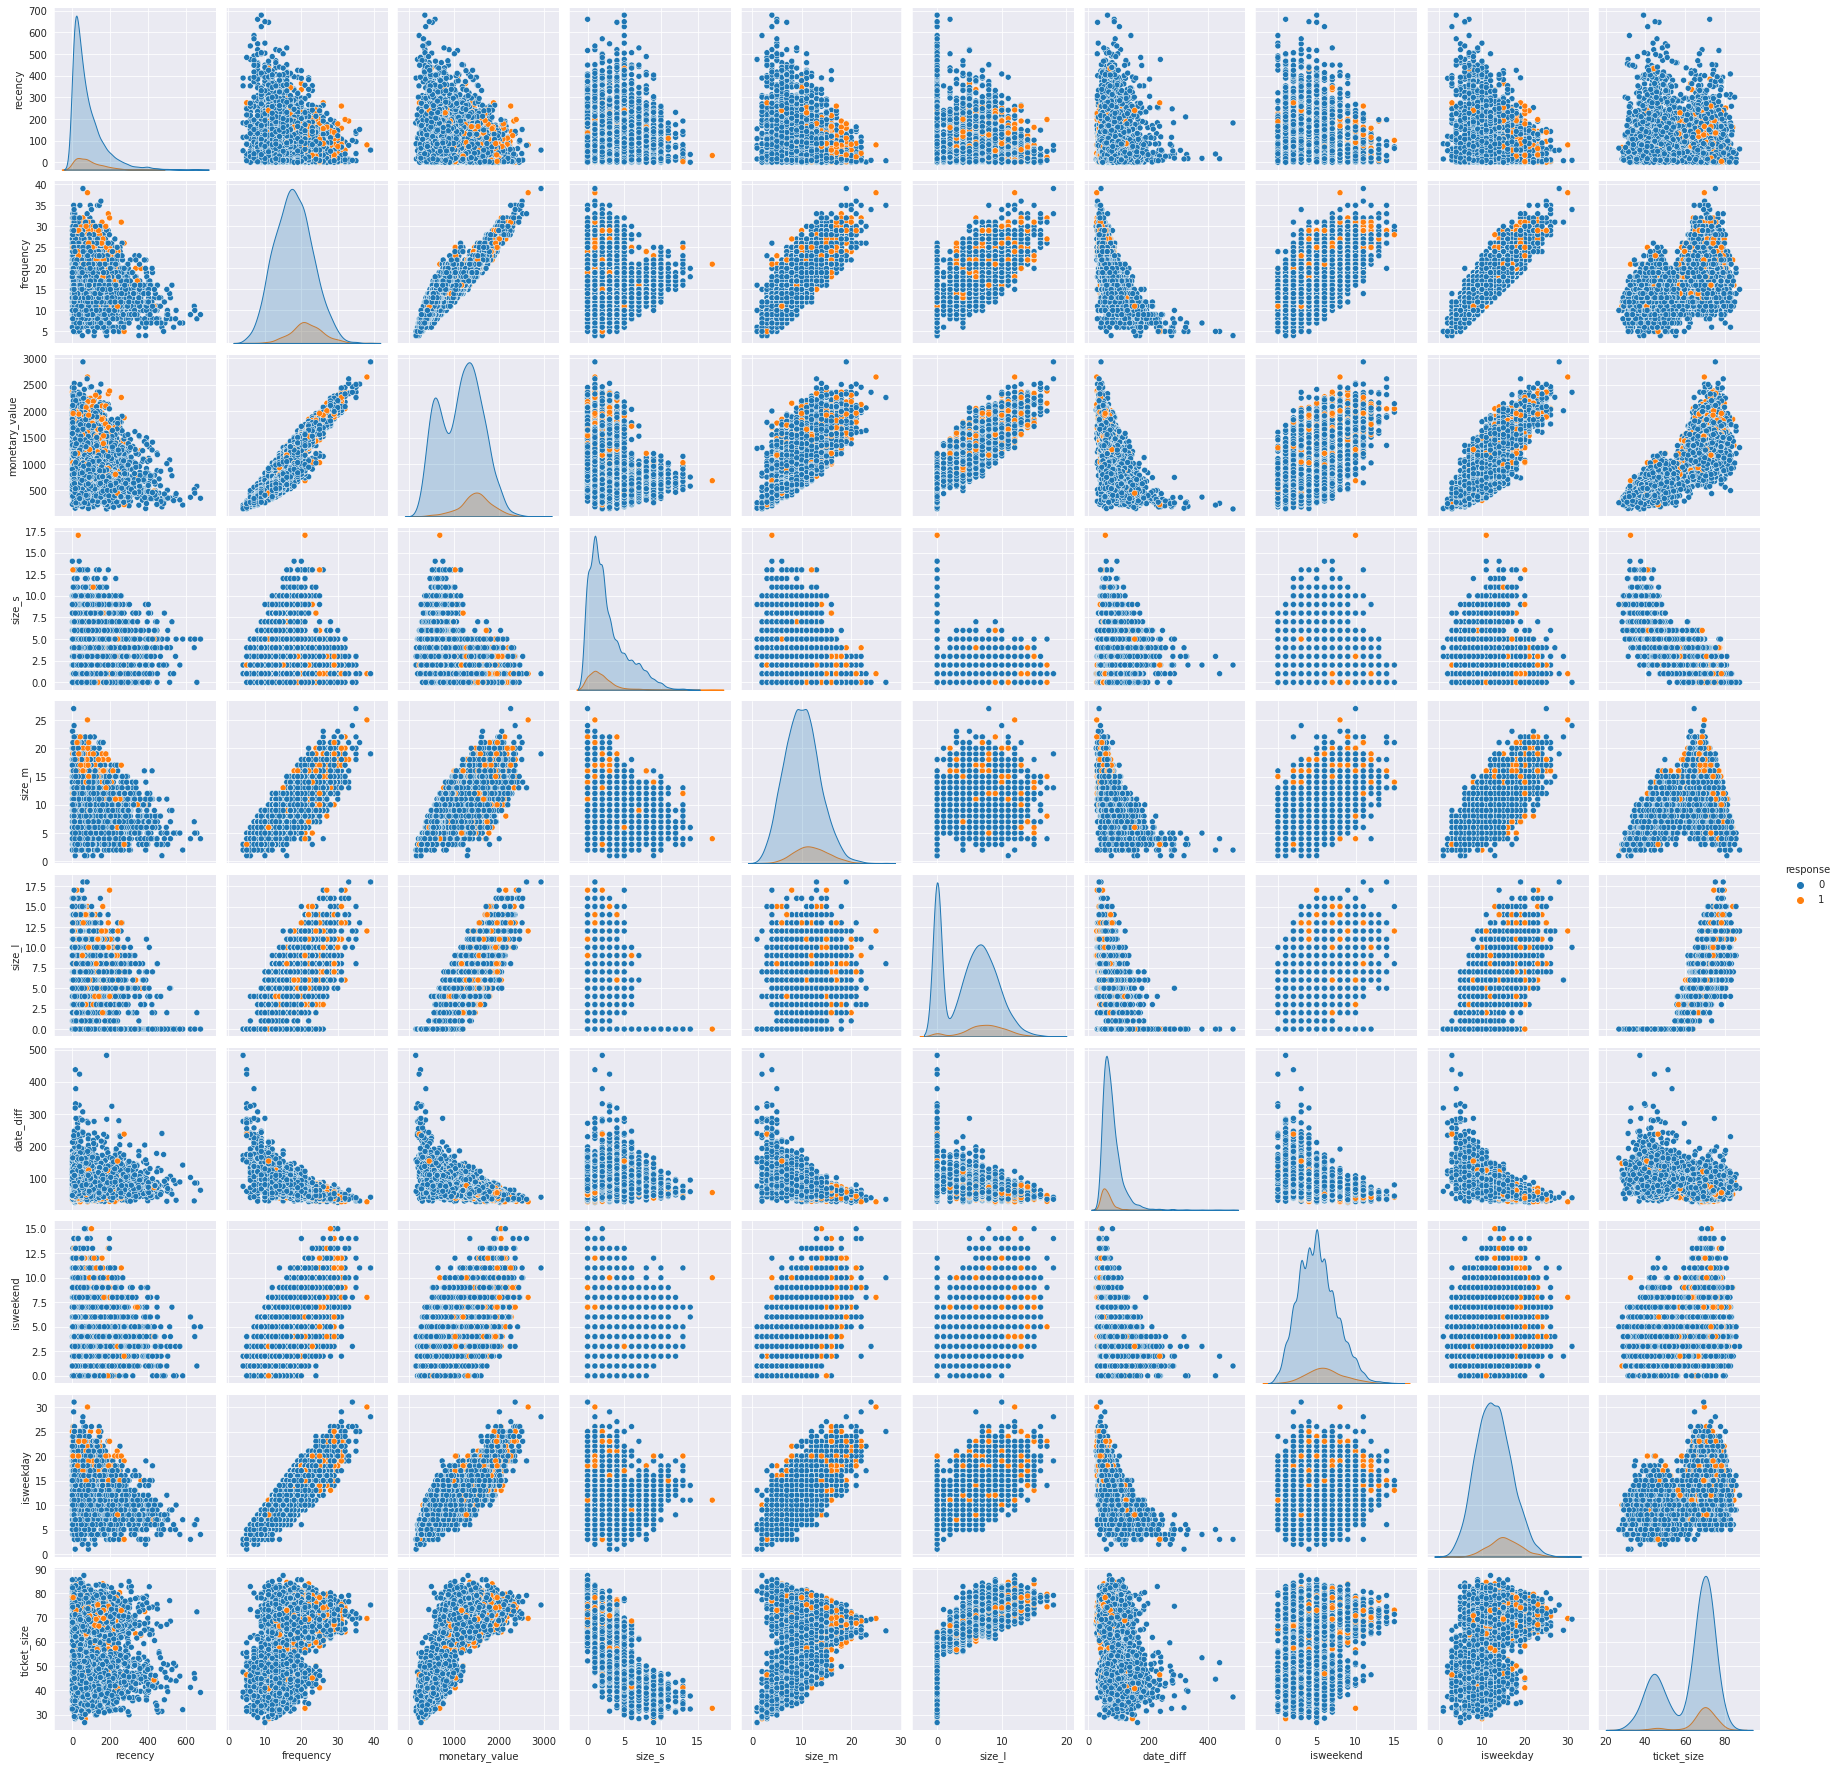

In [ ]:
sns.pairplot(total_response,hue = 'response') 

In [ ]:
# splite x,y  data
total_response.head()


,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size,response
0,CS1112,62.0,15,1012,2,9,4,50.873523,5,10,67.466667,0
1,CS1113,36.0,20,1490,1,9,10,54.685812,3,17,74.500000,0
2,CS1114,33.0,19,1432,1,9,9,73.693168,6,13,75.368421,1
3,CS1115,12.0,22,1659,0,13,9,55.413425,6,16,75.409091,1
4,CS1116,204.0,13,857,0,8,4,107.361010,1,12,65.923077,1


In [ ]:
# Under sampling 
X = total_response.iloc[:,1:-1]
y = total_response.iloc[:, -1]
list(X.shape)[1]
X_col = X.columns

In [ ]:
# ## Feature importtance
# from sklearn.datasets import make_regression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_classification
# from sklearn.tree import DecisionTreeClassifier
# from matplotlib import pyplot
# X, y = make_classification(n_samples=1000, n_features=list(X.shape)[1], n_informative=3, n_redundant=2, random_state=123) ## random_state =  123 
# #model_impor =  DecisionTreeClassifier()
# model_impor = DecisionTreeClassifier()
# model_impor.fit(X,y)
# print(type(model_impor.feature_importances_) )
# feature_score = model_impor.feature_importances_

# feture_impro = pd.DataFrame(feature_score, index= X_col , columns=['Feature_importance'])
# feture_impro = feture_impro[feture_impro['Feature_importance'] >= 0.0]
# feture_impro.sort_values('Feature_importance', ascending=False)
# display(feture_impro.sort_values('Feature_importance', ascending=False))
# feture_impro = list(feture_impro.index)
# print(feture_impro)

In [ ]:
## Feature selection 
total_response1 = total_response.copy()
total_response1.head()

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size,response
0,CS1112,62.0,15,1012,2,9,4,50.873523,5,10,67.466667,0
1,CS1113,36.0,20,1490,1,9,10,54.685812,3,17,74.500000,0
2,CS1114,33.0,19,1432,1,9,9,73.693168,6,13,75.368421,1
3,CS1115,12.0,22,1659,0,13,9,55.413425,6,16,75.409091,1
4,CS1116,204.0,13,857,0,8,4,107.361010,1,12,65.923077,1


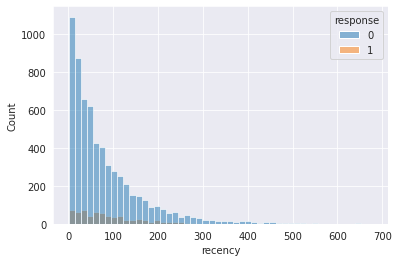

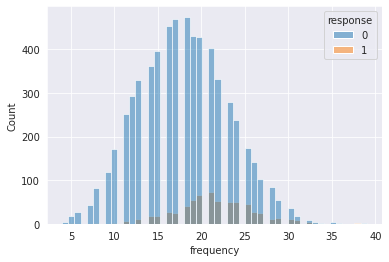

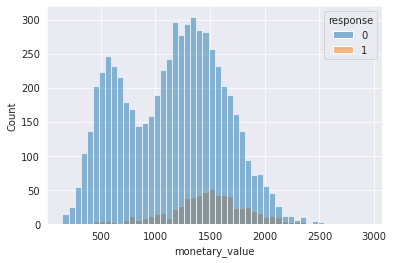

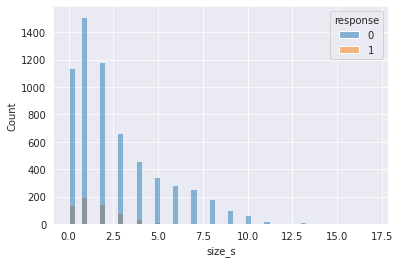

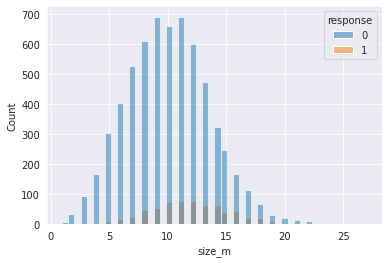

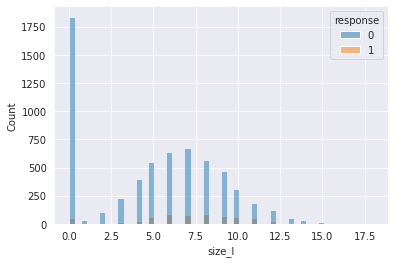

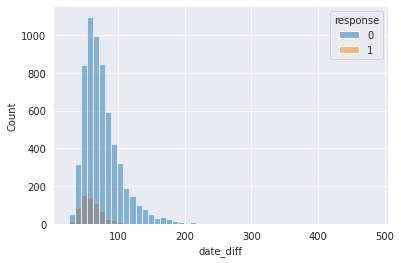

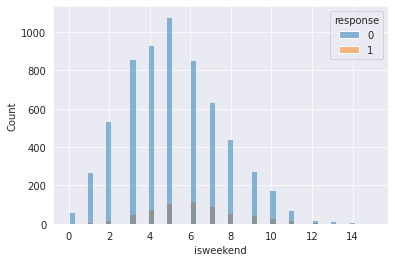

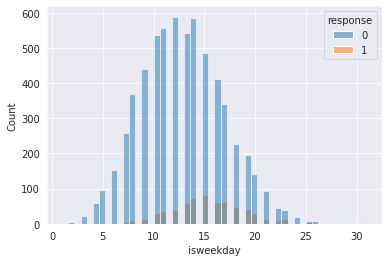

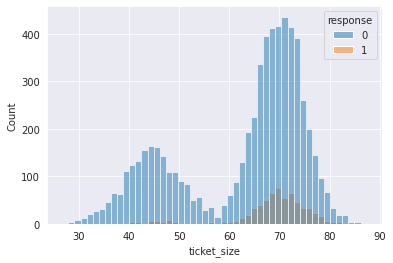

In [ ]:
## Draw histrograme graph 
%matplotlib inline
for i in  total_response1.iloc[:,1:-1] :
  fig , ax = plt.subplots()
#response_model.hist( column='frequency', ax= ax, color = 'teal')
  #non_response_model.hist(column = i , ax=ax,)
  sns.histplot(data=total_response1, x= i,bins=50, hue='response')
  plt.show()
  #sns.histplot(data=df, x='avg_spend_24m',bins=50, hue='response', ax=axes[3])

In [ ]:
# ### filter out some data ignore the campaign  with  ticket size below 60 and frequentcy  below 20 -35 
# fo_data =  total_response1[((total_response1['ticket_size'] >= 60) & (total_response1['frequency']>= 20))]
# fo_data.shape
# # fo_data_count =  fo_data.groupby(by='response').count().reset_index()
# # fo_data_count.plot.bar(x='response',y='frequency')

In [ ]:
## Find histrigram with response and non-response campaign 
response_model = total_response1[total_response1.response == 1]
non_response_model = total_response1[total_response1.response == 0]
response_model.head()
non_response_model.head()

,customer_id,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size,response
0,CS1112,62.0,15,1012,2,9,4,50.873523,5,10,67.466667,0
1,CS1113,36.0,20,1490,1,9,10,54.685812,3,17,74.500000,0
5,CS1117,258.0,17,1185,1,11,5,100.191296,5,12,69.705882,0
7,CS1119,12.0,15,1158,2,4,9,53.231869,2,13,77.200000,0
8,CS1120,11.0,24,1677,0,15,9,82.902462,5,19,69.875000,0


In [ ]:
# Dataset and split data 
# X1 = total_response1.iloc[:,1:-1] #fo_data #total_response1
# y1 = total_response1.iloc[:,-1]
X1 = total_response1.iloc[:,1:-1]
y1 = total_response1.iloc[:,-1]

In [ ]:
X1.head()

,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size
0,62.0,15,1012,2,9,4,50.873523,5,10,67.466667
1,36.0,20,1490,1,9,10,54.685812,3,17,74.500000
2,33.0,19,1432,1,9,9,73.693168,6,13,75.368421
3,12.0,22,1659,0,13,9,55.413425,6,16,75.409091
4,204.0,13,857,0,8,4,107.361010,1,12,65.923077


In [ ]:
xc = X1.columns
xc

Index(['recency', 'frequency', 'monetary_value', 'size_s', 'size_m', 'size_l',
       'date_diff', 'isweekend', 'isweekday', 'ticket_size'],
      dtype='object')

In [ ]:
## Train test splite data 

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=123)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 10)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 10)
Number transactions y_test dataset:  (2066,)


In [ ]:
X_train.head()

,recency,frequency,monetary_value,size_s,size_m,size_l,date_diff,isweekend,isweekday,ticket_size
553,156.0,16,1033,1,9,6,72.630179,6,10,64.562500
6447,2.0,12,614,4,8,0,84.633112,4,8,51.166667
2035,159.0,17,1211,0,10,7,71.483331,3,14,71.235294
5538,186.0,15,682,5,10,0,65.734272,6,9,45.466667
2946,226.0,16,1117,0,11,5,70.636898,5,11,69.812500


# Under Sampling 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

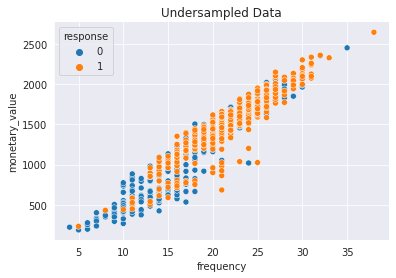

In [ ]:
## handleing imbalance 
# Under Sampling 
rus = RandomUnderSampler(random_state=123)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value', 'size_s', 'size_m', 'size_l',
       'date_diff', 'isweekend', 'isweekday', 'ticket_size','response']


sns.scatterplot(data=df_undersampled, x='frequency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

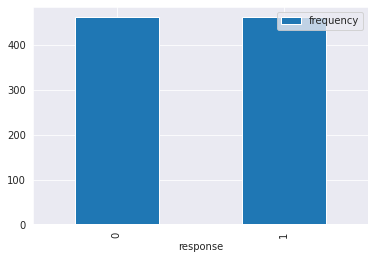

In [ ]:
under_count =  df_undersampled.groupby(by='response').count().reset_index()
under_count.plot.bar(x='response',y='frequency')

# Over Sampling


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

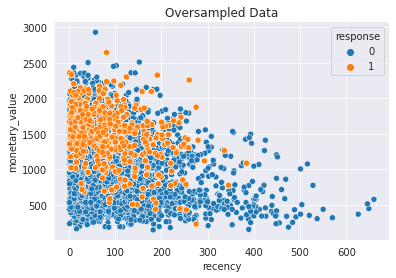

In [ ]:
# Fixing imbalanced with Oversampling 
ros = RandomOverSampler(random_state=123)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value', 'size_s', 'size_m', 'size_l',
       'date_diff', 'isweekend', 'isweekday', 'ticket_size','response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

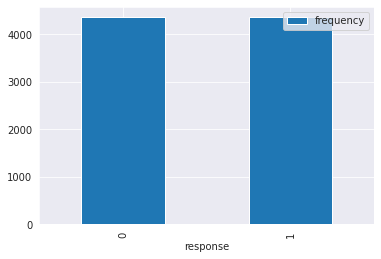

In [ ]:
over_count =  df_oversampled.groupby(by='response').count().reset_index()
over_count.plot.bar(x='response',y='frequency')

# SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

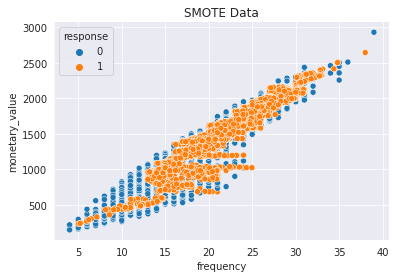

In [ ]:
### SMOTE ###
sm = SMOTE(random_state=123)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns=  ['recency', 'frequency', 'monetary_value', 'size_s', 'size_m', 'size_l',
       'date_diff', 'isweekend', 'isweekday', 'ticket_size','response']

sns.scatterplot(data=df_SMOTE, x='frequency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")


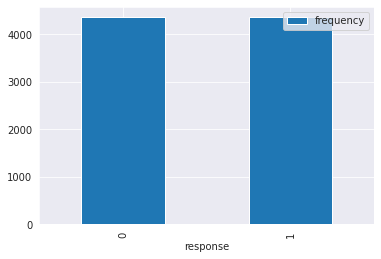

In [ ]:
SMOTE_count =  df_SMOTE.groupby(by='response').count().reset_index()
SMOTE_count.plot.bar(x='response',y='frequency')

In [ ]:
### Standardize training data 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train

array([[ 0.88087618, -0.41722229, -0.32191513, ...,  0.3297892 ,
        -0.71604077,  0.11443098],
       [-0.94602669, -1.17728542, -1.21307921, ..., -0.49072429,
        -1.19346735, -0.96830867],
       [ 0.9164652 , -0.2272065 ,  0.05667009, ..., -0.90098104,
         0.23881238,  0.65377023],
       ...,
       [-0.37660242, -0.41722229, -0.31128071, ...,  1.1503027 ,
        -1.19346735,  0.13968929],
       [ 0.72665711, -0.60723807, -0.34956461, ..., -0.49072429,
        -0.47732748,  0.39227241],
       [ 0.37076694, -0.98726964, -0.49206579, ...,  0.3297892 ,
        -1.43218063,  0.82127513]])

# Under sampling with Regression

In [ ]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       461
           1       0.65      0.72      0.68       461

    accuracy                           0.67       922
   macro avg       0.67      0.67      0.67       922
weighted avg       0.67      0.67      0.67       922

test set
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1880
           1       0.17      0.73      0.27       186

    accuracy                           0.65      2066
   macro avg       0.56      0.68      0.52      2066
weighted avg       0.89      0.65      0.72      2066



#################### Regression Model with under sampling ####################
tn: 1197  fp: 683  fn: 50  tp:  136


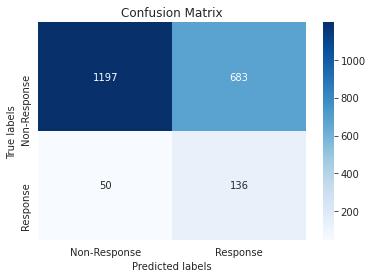

In [266]:
from sklearn.metrics import confusion_matrix

print('#'* 20 + " Regression Model with under sampling "+ '#'*20 )
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

#################### Regression Model with under sampling ####################


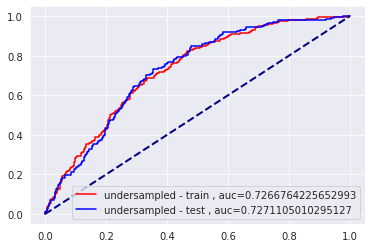

In [267]:
print('#'* 20 + " Regression Model with under sampling "+ '#'*20 )
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

# XGboost With Undersampling

In [ ]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.686761
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.697962
[2]	validation_0-auc:0.697962
[3]	validation_0-auc:0.710139
[4]	validation_0-auc:0.70333
[5]	validation_0-auc:0.717942
[6]	validation_0-auc:0.726514
[7]	validation_0-auc:0.725373
[8]	validation_0-auc:0.726644
[9]	validation_0-auc:0.726074
[10]	validation_0-auc:0.727422
[11]	validation_0-auc:0.728426
[12]	validation_0-auc:0.729691
[13]	validation_0-auc:0.728949
[14]	validation_0-auc:0.730073
[15]	validation_0-auc:0.731616
[16]	validation_0-auc:0.731964
[17]	validation_0-auc:0.733318
[18]	validation_0-auc:0.733598
[19]	validation_0-auc:0.734667
[20]	validation_0-auc:0.734193
[21]	validation_0-auc:0.734283
[22]	validation_0-auc:0.734031
[23]	validation_0-auc:0.732787
[24]	validation_0-auc:0.733895
Stopping. Best iteration:
[19]	validation_0-auc:0.734667

training set
              precision    recall  f1-score   support

           0      

#################### XGBoost with under sampling ####################
tn: 1016  fp: 864  fn: 35  tp:  151


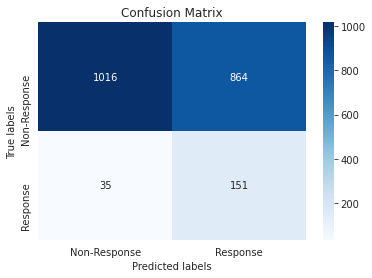

In [ ]:
from sklearn.metrics import confusion_matrix
print('#'* 20 + " XGBoost with under sampling "+ '#'*20 )
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

#################### XGBoost with under sampling ####################


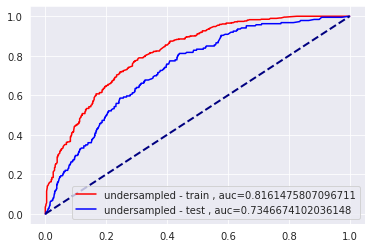

In [ ]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))
print('#'* 20 + " XGBoost with under sampling "+ '#'*20 )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

# XGBoost model with SMOTE'

In [268]:
## SMOTE ###
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.681443
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.683302
[2]	validation_0-auc:0.669974
[3]	validation_0-auc:0.674407
[4]	validation_0-auc:0.679388
[5]	validation_0-auc:0.680395
[6]	validation_0-auc:0.693598
[7]	validation_0-auc:0.69561
[8]	validation_0-auc:0.693654
[9]	validation_0-auc:0.698642
[10]	validation_0-auc:0.698234
[11]	validation_0-auc:0.698051
[12]	validation_0-auc:0.701303
[13]	validation_0-auc:0.700576
[14]	validation_0-auc:0.701664
[15]	validation_0-auc:0.702083
[16]	validation_0-auc:0.704341
[17]	validation_0-auc:0.705255
[18]	validation_0-auc:0.70771
[19]	validation_0-auc:0.708099
[20]	validation_0-auc:0.709514
[21]	validation_0-auc:0.708698
[22]	validation_0-auc:0.707008
[23]	validation_0-auc:0.709337
[24]	validation_0-auc:0.708453
[25]	validation_0-auc:0.709822
[26]	validation_0-auc:0.70888
[27]	validation_0-auc:0.709417
[28]	validation_0-auc:0.707584
[29]	validation_0-auc:0.70582

#################### Xgboost with SMOTE ####################
tn: 1542  fp: 338  fn: 115  tp:  71


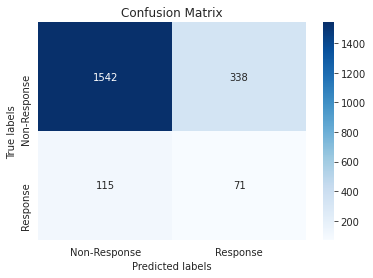

In [269]:
from sklearn.metrics import plot_confusion_matrix
print('#'* 20 + " Xgboost with SMOTE "+ '#'*20 )
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

#################### Xgboost with SMOTE ####################


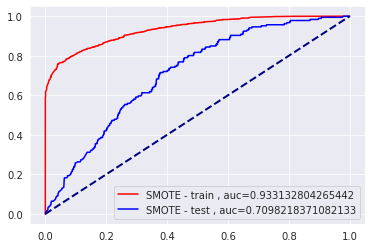

In [270]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))
print('#'* 20 + " Xgboost with SMOTE "+ '#'*20 )
y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [271]:
## Regression Under sampling 
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       461
           1       0.65      0.72      0.68       461

    accuracy                           0.67       922
   macro avg       0.67      0.67      0.67       922
weighted avg       0.67      0.67      0.67       922

test set
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1880
           1       0.17      0.73      0.27       186

    accuracy                           0.65      2066
   macro avg       0.56      0.68      0.52      2066
weighted avg       0.89      0.65      0.72      2066



tn: 1197  fp: 683  fn: 50  tp:  136


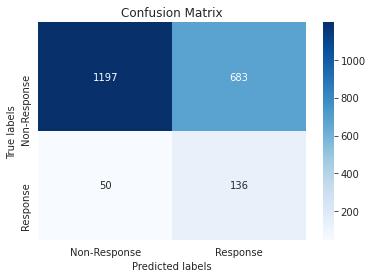

In [272]:
from sklearn.metrics import plot_confusion_matrix
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

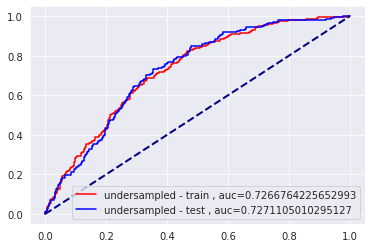

In [273]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

## Regression with SMOTE ###


In [ ]:
## REgression with SMOTE ###
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_smote = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_smote.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_smote.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.68      0.61      0.65      4357
           1       0.65      0.71      0.68      4357

    accuracy                           0.66      8714
   macro avg       0.66      0.66      0.66      8714
weighted avg       0.66      0.66      0.66      8714

test set
              precision    recall  f1-score   support

           0       0.96      0.63      0.76      1880
           1       0.16      0.70      0.26       186

    accuracy                           0.64      2066
   macro avg       0.56      0.67      0.51      2066
weighted avg       0.88      0.64      0.72      2066



tn: 1197  fp: 683  fn: 50  tp:  136


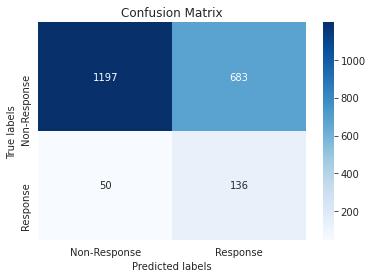

In [274]:
from sklearn.metrics import plot_confusion_matrix
tn, fp, fn, tp  = confusion_matrix(expected_y, predicted_y).ravel()
print('tn:',tn , ' fp:',fp, ' fn:',fn, ' tp: ',tp)  ##  fp predict  use to not -use 
cm = confusion_matrix(expected_y, predicted_y)
cm
#plt.imshow(cm, cmap='binary')
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap = 'Blues');  #YlGn
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Non-Response', 'Response'])
ax.yaxis.set_ticklabels(['Non-Response', 'Response']);

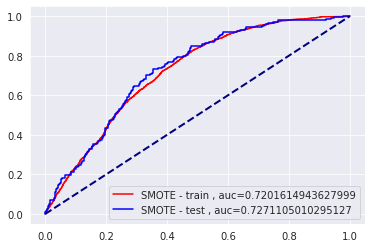

In [275]:
y_score_train = logreg_model_under.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()  


# y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
# fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
# auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
# plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

# y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
# fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
# auc_test = roc_auc_score(y_test, y_score_test[:,1])
# plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.legend(loc=4)
# plt.show()